In [5]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import simpy

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import q_network
from tf_agents.networks import categorical_q_network

from tf_agents.policies import policy_saver
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.trajectories import time_step as ts
from tf_agents.specs import tensor_spec
#from env.RideSimulator.Grid import Grid
import tf_agents


import os,sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from RideSimulator.taxi_sim import run_simulation
from RideSimulator import reward_parameters as rp

Loading trip data...
Data loading complete


In [6]:
#register custom env
import gym

gym.envs.register(
     id='taxi-v0',
     entry_point='env.taxi:TaxiEnv',
     max_episode_steps=1500,
     kwargs={'state_dict':None},
)

In [7]:
#hyper params

num_iterations = 40 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 10  # @param {type:"integer"}

num_eval_episodes = 2  # @param {type:"integer"}
eval_interval = 5  # @param {type:"integer"}action

In [8]:
#load taxi env
env_name = "taxi-v0"
env = suite_gym.load(env_name)

tf_env = tf_py_environment.TFPyEnvironment(env)
reset = tf_env.reset()


In [9]:
#agent and policy
fc_layer_params = (100,)


q_net = q_network.QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()


#random policy
random_policy = random_tf_policy.RandomTFPolicy(tf_env.time_step_spec(),tf_env.action_spec())

#agent policy
eval_policy = agent.policy
collect_policy = agent.collect_policy

#replay buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_max_length)
    
saver = policy_saver.PolicySaver(eval_policy, batch_size=None)


In [10]:
#catagorical dqn agent
gamma = 0.99
num_atoms = 51  # @param {type:"integer"}
min_q_value = -20  # @param {type:"integer"}
max_q_value = 20  # @param {type:"integer"}
n_step_update = 2  # @param {type:"integer"}
categorical_q_net = categorical_q_network.CategoricalQNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    num_atoms=num_atoms,
    fc_layer_params=fc_layer_params)

agent = categorical_dqn_agent.CategoricalDqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    categorical_q_network=categorical_q_net,
    optimizer=optimizer,
    min_q_value=min_q_value,
    max_q_value=max_q_value,
    n_step_update=n_step_update,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=gamma,
    train_step_counter=train_step_counter)
agent.initialize()

#agent policy
eval_policy = agent.policy
collect_policy = agent.collect_policy

#replay buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_max_length)

In [11]:
#create dataset and iterator
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=n_step_update+1).prefetch(3)

iterator = iter(dataset)
print(iterator)

In [12]:
"""
policy.action(reset)
#tf_env.time_step_spec()
print(reset)
#print(env.reset())
#print(ts.restart(tf.convert_to_tensor(np.array([0,0,0,0], dtype=np.int32), dtype=tf.float32)))
print(" ")
print(ts.TimeStep(tf.constant([0]), tf.constant([0.0]), tf.constant([1.0]),tf.convert_to_tensor(np.array([[0,0,0,0]], dtype=np.int32), dtype=tf.float32)))

#print(tensor_spec.to_array_spec(reset))
#encoder_func = tf_agents.utils.example_encoding.get_example_encoder(env.reset())
#encoder_func(env.reset())
"""

#run_simulation(policy)
#ts.termination(np.array([1,2,3,4], dtype=np.int32), reward=0.0)
#ts.transition(np.array([1,2,3,4], dtype=np.int32), reward=0.0, discount=1.0)

'\npolicy.action(reset)\n#tf_env.time_step_spec()\nprint(reset)\n#print(env.reset())\n#print(ts.restart(tf.convert_to_tensor(np.array([0,0,0,0], dtype=np.int32), dtype=tf.float32)))\nprint(" ")\nprint(ts.TimeStep(tf.constant([0]), tf.constant([0.0]), tf.constant([1.0]),tf.convert_to_tensor(np.array([[0,0,0,0]], dtype=np.int32), dtype=tf.float32)))\n\n#print(tensor_spec.to_array_spec(reset))\n#encoder_func = tf_agents.utils.example_encoding.get_example_encoder(env.reset())\n#encoder_func(env.reset())\n'

In [13]:
#create a static environment for evaluation purposes

#policy that always accepts
class AcceptPolicy:
  def __init__(self):
    print("init")

  def action(self, obs):
    return (tf.constant([1]))

acceptPol = AcceptPolicy()

eval_env = run_simulation([acceptPol])
#print(eval_env)

init
hex count  114
Number of trips generated: 1939


In [14]:

#policy which accepts all positive reward trips (for evaluation purposes)
#this policy looks at pickup distance & trip distance and calculates trip reward
class AcceptPositiveTripsPolicy:
  def __init__(self):
    print("init")

  def action(self, obs):
    observations = obs.observation.numpy()[0]
    trip_reward = (observations[1] * rp.unit_reward) - ((observations[0] + observations[1]) * rp.per_km_cost)
    #print(trip_reward)
    if (trip_reward >= 0):
        return (tf.constant([1]))
    else:
        return (tf.constant([0]))

accpt_positive_trips_policy = AcceptPositiveTripsPolicy()

init


In [15]:
#evaluate a trained policy with respect to a pre-generated static environment
def evaluatePolicy(policy, eval_env):
    episode_reward = 0
    hrly_accepted_trips = np.zeros(24)
    hrly_trip_counts = np.zeros(24)
    hrly_acceptance_rates = []
    for state_list in eval_env[0]:
        states = []
        driver_reward = 0
        
        for i in range(len(state_list)):
            state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
            action = policy.action(state_tf)
            #action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
            if (action[0].numpy() == 1):
                reward = state_list[i]["reward"]
                print(np.array([state_list[i]["observation"]]))
                hrly_accepted_trips[int(np.array([state_list[i]["observation"]])[0][2])] +=1
            else:
                reward = 0
            print (reward)
            driver_reward += reward
            hrly_trip_counts[int(np.array([state_list[i]["observation"]])[0][2])] +=1
            
            
        episode_reward += driver_reward
        print("driver reward ", driver_reward)
    print("total reward ", episode_reward)
    
    #find average acceptance for each hour
    for j in range(24):
        hrly_acceptance_rates.append(hrly_accepted_trips[j]/hrly_trip_counts[j])
    print (hrly_acceptance_rates)

evaluatePolicy(acceptPol, eval_env)

driver reward  0
[[ 2.9 16.1  6.  40.  91. ]]
-59.28494895833337
[[ 7.  14.7  7.  39.  86. ]]
-95.36167895833334
[[11.3 21.4  8.  38.  75. ]]
-75.58083395833339
[[14.5 17.6 11.  37.  63. ]]
5.666161041666641
[[ 5.7 23.8 13.  36.  55. ]]
-8.941428958333375
[[ 9.4 17.8 13.  35.  79. ]]
-51.691428958333404
[[ 6.  14.1 13.  34.  74. ]]
-35.441428958333375
[[13.9 16.8 13.  33.  74. ]]
-87.9414289583334
[[15.6 10.9 13.  32.  86. ]]
-115.44142895833338
[[ 2.9  9.4 13.  31.  85. ]]
-23.941428958333375
[[ 1.5 39.5 13.  30.  42. ]]
61.80857104166665
[[15.  26.5 14.  29.  86. ]]
-56.805813958333374
[[18.1 18.7 14.  28.  78. ]]
-99.55581395833337
[[19.1 22.8 14.  27.  80. ]]
-96.80581395833343
[[16.1 16.  15.  26.  97. ]]
-66.58103395833339
[[ 3.5  7.2 15.  25.  85. ]]
5.918966041666621
[[ 4.8 10.1 15.  24.  67. ]]
3.4189660416666356
[[ 6.8 10.4 15.  23.  86. ]]
-10.831033958333379
[[23.2  4.7 15.  22.  66. ]]
-148.08103395833336
[[ 5.8 16.  15.  21.  49. ]]
10.668966041666607
[[ 3.9 17.4 15.  20.

[[ 9.2  4.1 15.   0.  50. ]]
-44.581033958333364
[[14.5 25.2 15.  -1.  97. ]]
-31.581033958333364
[[ 8.5 29.2 15.  -1.  80. ]]
23.418966041666636
[[12.5 20.8 16.  -1.  90. ]]
-65.1464189583333
[[ 9.6 33.6 16.  -1.  31. ]]
-11.396418958333356
[[21.6  4.3 16.  -1.  61. ]]
-174.64641895833336
[[20.4  6.6 16.  -1.  90. ]]
-159.89641895833333
[[ 8.1  5.7 16.  -1.  73. ]]
-69.89641895833333
[[ 5.9 19.1 16.  -1.  67. ]]
-19.896418958333328
[[13.7 39.8 17.  -1.  25. ]]
-61.655048958333396
[[ 6.7  5.5 17.  -1.  25. ]]
-94.90504895833337
[[ 8.1 28.1 17.  -1.  67. ]]
-48.90504895833337
[[ 6.   8.8 17.  -1.  66. ]]
-81.40504895833337
[[12.2  8.  18.  -1.  85. ]]
-116.32087895833337
[[11.8 26.4 18.  -1.  43. ]]
-67.32087895833337
[[ 9.3  7.7 18.  -1.  54. ]]
-95.32087895833337
[[12.6 17.  18.  -1.  49. ]]
-96.82087895833337
[[15.1 20.2 18.  -1.  62. ]]
-107.57087895833337
[[22.1 29.2 18.  -1.  80. ]]
-137.57087895833337
[[21.3  9.7 20.  -1.  86. ]]
-122.54029395833336
[[ 8.  18.9 20.  -1.  66. ]]
0

[[ 6.2  6.2  9.   9.  44. ]]
12.637371041666654
[[14.1  7.5 10.   8.  67. ]]
-9.97801395833335
[[ 4.2 15.8 10.   7.  42. ]]
85.02198604166665
[[ 4.3 10.6 11.   6.  61. ]]
64.66616104166665
[[ 6.5 36.7 11.   5.  33. ]]
113.41616104166667
[[ 5.6 40.6 12.   4.  74. ]]
93.86337104166665
[[ 8.8 28.5 12.   3.  43. ]]
39.61337104166665
[[10.7 37.5 12.   2.  91. ]]
47.86337104166665
[[15.7 14.6 12.   1.  91. ]]
3953.1133710416666
[[10.2 28.5 12.   0.  54. ]]
29.113371041666653
[[ 2.9 24.6 12.  -1.  85. ]]
74.11337104166665
[[ 6.8 31.  12.  -1.  49. ]]
60.86337104166665
[[ 5.5 19.3 13.  -1.  62. ]]
-18.691428958333375
[[20.8 16.3 13.  -1.  79. ]]
-140.94142895833338
[[ 1.1 17.3 13.  -1.  97. ]]
9.308571041666596
[[11.2 10.5 13.  -1.  73. ]]
-83.44142895833338
[[ 4.2  2.4 13.  -1.  79. ]]
-51.191428958333375
[[ 6.5 27.1 14.  -1.  44. ]]
8.444186041666626
[[12.5 10.5 14.  -1.  43. ]]
-78.05581395833337
[[17.4 29.2 14.  -1.  91. ]]
-68.05581395833332
[[13.8 11.3 15.  -1.  79. ]]
-61.08103395833338

[[10.4 25.8 17.  -1.  74. ]]
-71.90504895833337
[[14.9 10.  17.  -1.  91. ]]
-145.15504895833337
[[11.1 20.1 17.  -1.  85. ]]
-91.4050489583334
[[ 2.5 29.2 17.  -1.  50. ]]
-4.155048958333367
[[18.1 16.8 17.  -1.  25. ]]
-152.15504895833342
[[ 6.6 30.1 17.  -1.  50. ]]
-32.65504895833337
[[20.1  4.8 17.  -1.  49. ]]
-197.1550489583334
[[16.  18.7 17.  -1.  55. ]]
-131.65504895833337
[[ 4.6 33.2 18.  -1.  27. ]]
3.6791210416665763
[[11.4 19.6 20.  -1.  50. ]]
-23.540293958333365
[[18.1 11.6 20.  -1.  91. ]]
-93.7902939583334
[[25.2  7.7 21.  -1.  73. ]]
-124.74296895833336
[[ 7.3  6.7 21.  -1.  73. ]]
7.007031041666636
[[ 9.5 35.1 21.  -1.  57. ]]
61.507031041666664
[[21.6  9.1  6.  -1.  67. ]]
-217.03494895833342
[[ 8.7  3.7  7.  -1.  66. ]]
-135.61167895833333
[[ 4. 23.  7. -1. 37.]]
-52.11167895833336
[[ 6.1 35.2  7.  -1.  66. ]]
-37.361678958333414
[[ 7.2 21.5  7.  -1.  62. ]]
-79.86167895833336
[[21.8 22.   7.  -1.  73. ]]
-188.11167895833336
[[13.  32.7  7.  -1.  49. ]]
-95.361678

[[ 5.   9.4 17.   2.  93. ]]
-72.40504895833337
[[ 5.   4.8 19.   1.  88. ]]
3946.523556041667
[[ 6.4 13.8 21.   0.  87. ]]
31.507031041666608
[[ 6.4 16.2 12.  -1.  57. ]]
26.863371041666653
[[19.7 13.6 14.  -1.  62. ]]
-124.30581395833335
[[10.  35.8 14.  -1.  20. ]]
3.944186041666626
[[19.2 17.5 16.  -1.  42. ]]
-123.64641895833333
[[ 6.3  2.1 16.  -1.  61. ]]
-65.39641895833333
[[ 6.  24.1 16.  -1.  26. ]]
-8.146418958333328
[[26.8 18.9 17.  -1.  31. ]]
-212.15504895833337
[[16.4 11.  17.  -1.  30. ]]
-153.90504895833337
[[15.9 11.6 17.  -1.  55. ]]
-148.65504895833337
[[ 7.1  1.3 17.  -1.  49. ]]
-108.40504895833337
[[ 9.6 12.9 17.  -1.  54. ]]
-98.15504895833337
[[ 8.8 21.8 17.  -1.  62. ]]
-69.90504895833337
[[ 6.8 23.6 17.  -1.  51. ]]
-50.405048958333396
[[19.6  6.5 21.  -1.  62. ]]
-85.74296895833336
[[11.8 17.5 21.  -1.  98. ]]
0.25703104166663593
[[20.4  9.  21.  -1.  85. ]]
-85.49296895833336
[[ 5.8 39.  21.  -1.  69. ]]
99.00703104166666
[[19.2  7.8  6.  -1.  56. ]]
-202.2

[[ 1.7 16.4 19.  -1.  44. ]]
0.2735560416666658
[[11.7 23.2 20.  -1.  51. ]]
-16.790293958333365
[[31. 13. 23. -1. 73.]]
-150.14969895833335
[[ 5.8 15.8  0.  -1.  90. ]]
22.825111041666617
[[27.4  3.4  3.  -1.  67. ]]
-205.6370489583333
[[16.8  4.7  5.  -1.  85. ]]
-134.42640895833333
[[12.8  6.   6.  -1.  73. ]]
-158.78494895833336
[[11.8 18.6  6.  -1.  67. ]]
-119.7849489583334
[[11.1 31.3  7.  -1.  93. ]]
-84.61167895833336
[[11.   7.3 13.  -1.  87. ]]
-89.94142895833338
[[ 6.9 13.8 14.  -1.  92. ]]
-27.805813958333403
[[ 7.2 16.2 15.  -1.  68. ]]
0.6689660416666072
[[15.2 17.1 15.  -1.  67. ]]
-57.081033958333364
[[14.9 26.6 16.  -1.  37. ]]
-68.64641895833333
[[ 4.7  9.9 16.  -1.  42. ]]
-33.89641895833334
[[11.5 11.4 16.  -1.  55. ]]
-81.14641895833333
[[ 7.5 45.3 16.  -1.  87. ]]
33.603581041666644
[[15.9  6.8 17.  -1.  92. ]]
-160.65504895833337
[[ 3.6 14.  17.  -1.  68. ]]
-50.40504895833337
[[ 7.6  8.8 18.  -1.  74. ]]
-79.82087895833335
[[18.  15.1 18.  -1.  73. ]]
-142.0708

[[17.7 18.7  8.  -1.  79. ]]
-130.33083395833336
[[ 7.7 21.5  8.  -1.  54. ]]
-48.33083395833336
[[ 1.8 18.   9.  -1.  78. ]]
75.13737104166665
[[11.5 16.9  9.  -1.  80. ]]
-0.36262895833334596
[[ 9.8  3.8  9.  -1.  74. ]]
-20.36262895833336
[[24.4 24.2  9.  -1.  78. ]]
-78.86262895833329
[[ 6.7  4.1  9.  -1.  85. ]]
3.637371041666654
[[ 5.2  6.8 11.  -1.  79. ]]
48.41616104166664
[[ 7.3 24.5 11.  -1.  50. ]]
76.91616104166667
[[11.6 13.4 11.  -1.  79. ]]
16.91616104166664
[[11.7  4.6 11.  -1.  78. ]]
-5.833838958333331
[[10.   4.7 12.  -1.  90. ]]
-28.886628958333347
[[12.4  2.  12.  -1.  66. ]]
-53.636628958333354
[[ 4.7 12.2 12.  -1.  85. ]]
29.613371041666667
[[ 3.4 19.3 12.  -1.  55. ]]
57.11337104166665
[[ 5.4 19.8 13.  -1.  73. ]]
-16.691428958333404
[[ 5.1 11.8 13.  -1.  85. ]]
-34.44142895833336
[[ 9.8  1.8 13.  -1.  73. ]]
-94.69142895833339
[[ 2.8 13.  13.  -1.  79. ]]
-14.191428958333375
[[ 2.  19.7 13.  -1.  99. ]]
8.558571041666625
[[12.5 29.6 23.  -1.  51. ]]
30.10030104

<ipython-input-15-24eec1607ea1>:32: RuntimeWarning: invalid value encountered in double_scalars
  hrly_acceptance_rates.append(hrly_accepted_trips[j]/hrly_trip_counts[j])


In [16]:
evaluatePolicy(accpt_positive_trips_policy, eval_env)

driver reward  0
[[ 2.9 16.1  6.  40.  91. ]]
-59.28494895833337
0
0
0
[[ 5.7 23.8 13.  36.  55. ]]
-8.941428958333375
0
0
0
0
[[ 2.9  9.4 13.  31.  85. ]]
-23.941428958333375
[[ 1.5 39.5 13.  30.  42. ]]
61.80857104166665
0
0
0
0
0
0
0
0
0
[[ 3.9 17.4 15.  20.  31. ]]
28.418966041666636
0
0
0
0
0
[[ 6.9 24.2 17.  14.  75. ]]
-49.65504895833337
0
[[ 0.8 30.8 18.  12.  49. ]]
26.179121041666633
[[ 3.9 17.5 18.  11.  43. ]]
-30.320878958333367
0
[[ 0.6 27.  18.   9.  85. ]]
18.179121041666633
[[ 1.6 40.5 18.   8.  63. ]]
44.42912104166663
0
[[ 2.4 19.8  7.   6.  26. ]]
-48.11167895833334
0
0
[[ 5.1 16.7 12.   3.  55. ]]
37.86337104166668
[[ 2.  15.9 12.   2.  62. ]]
59.11337104166665
0
0
0
0
[[ 5.9 51.3 12.  -1.  45. ]]
118.36337104166665
0
driver reward  174.09959958333297
0
[[ 4.6 21.3  5.  39.  86. ]]
-1.426408958333326
[[ 2.7 15.   8.  38.  74. ]]
-27.080833958333372
[[ 5.  27.6  8.  37.  42. ]]
-12.830833958333358
[[ 0.7 17.7  8.  36.  31. ]]
-5.330833958333358
0
0
0
0
[[ 2.6 21.3 1

0
0
0
0
0
0
0
0
[[ 3.1 10.5 14.   7.  90. ]]
-7.555813958333374
0
[[10.7 43.2 14.   5.  26. ]]
17.19418604166657
0
0
0
0
0
0
[[ 6.8 25.3 16.  -1.  55. ]]
-11.146418958333328
0
0
[[ 4.9 17.2 17.  -1.  61. ]]
-52.15504895833337
[[ 4.8 28.4 17.  -1.  56. ]]
-23.40504895833334
0
0
0
0
0
0
0
0
[[ 5.8 39.3 18.  -1.  37. ]]
9.92912104166669
[[ 2.1  8.7 19.  -1.  37. ]]
-21.976443958333363
[[ 4.2 31.1 19.  -1.  73. ]]
18.273556041666552
[[ 1.4 24.4 19.  -1.  68. ]]
22.523556041666666
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
[[ 1.3 15.   9.  -1.  86. ]]
71.38737104166665
0
0
[[ 2.8 13.  11.  -1.  73. ]]
81.91616104166664
0
0
0
0
0
[[ 0.8 14.   8.  -1.  50. ]]
-15.330833958333372
0
0
0
[[ 4.7 34.9 12.  -1.  66. ]]
86.36337104166665
0
0
0
[[ 6.8 26.3 13.  -1.  32. ]]
-10.941428958333375
[[ 7.3 25.  17.  -1.  18. ]]
-50.65504895833334
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
[[ 4.2 35.7 20.  -1.  63. ]]
70.70970604166655
0
0
0
0
0
0
0
0
0
0
0
0
0
[[ 5.2 20.4 12.  -1.  61. ]]
46.36337104166668
0
0
[[ 9.3 30.2 12.  -1.

[[ 5.2 24.7 10.  12.  75. ]]
99.77198604166665
0
0
0
0
0
0
0
[[ 0.6  4.2 13.   4.  85. ]]
-19.691428958333372
0
0
[[ 0.8  6.6 13.   1.  54. ]]
3984.8085710416667
0
0
0
[[ 3.  28.4 14.  -1.  43. ]]
37.944186041666626
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
[[ 7.  28.5 19.  -1.  31. ]]
-9.226443958333391
0
[[ 3.6 43.3 19.  -1.  57. ]]
53.27355604166661
0
0
0
[[ 2.   7.6  8.  -1.  73. ]]
-40.33083395833337
[[ 6.9 32.3  8.  -1.  37. ]]
-15.3308339583333
0
0
0
[[ 0.9 12.2  9.  -1.  19. ]]
67.38737104166665
0
[[ 5. 45.  9. -1. 87.]]
118.63737104166665
0
0
[[ 5.6 26.6 11.  -1.  43. ]]
94.91616104166664
0
[[ 3.1 29.8 12.  -1.  38. ]]
85.61337104166665
[[ 7.7 35.2 15.  -1.  85. ]]
44.41896604166658
0
0
0
0
0
[[ 7.6 32.2 17.  -1.  92. ]]
-34.90504895833345
[[ 7.9 34.  17.  -1.  32. ]]
-32.655048958333396
0
0
0
0
[[11.  37.9 11.  -1.  64. ]]
82.66616104166667
0
[[ 1.5 15.9 18.  -1.  63. ]]
-16.320878958333367
0
[[ 2.  23.9 18.  -1.  87. ]]
-0.07087895833336688
0
0
0
[[ 5.5 21.1 20.  -1.  30. ]]
24.45970604

<ipython-input-15-24eec1607ea1>:32: RuntimeWarning: invalid value encountered in double_scalars
  hrly_acceptance_rates.append(hrly_accepted_trips[j]/hrly_trip_counts[j])


In [18]:
# compute average returnstep
def compute_avg_return(policy, num_episodes=10):
    total_reward = 0

    for i in range (num_episodes):
        #run one episode of simulation and record states
        state_lists = run_simulation([policy])
        episode_reward = 0
        for state_list in state_lists[0]:
            states = []
            driver_reward = 0

            #convert states directly to tf timesteps
            for i in range(len(state_list)):
                state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                driver_reward += state_tf.reward
            episode_reward += driver_reward
        
        #take average reward for all drivers in the episode
        episode_reward = episode_reward / len(state_lists)
        total_reward += episode_reward

    avg_return = total_reward / num_episodes
    print(avg_return)
    return avg_return.numpy()


In [19]:
#collect trajectories

def collect_data(num_iterations, policy, replay_buffer):
    for i in range (num_iterations):
        #run one episode of simulation and record states
        state_lists = run_simulation([policy])
        print("driver count : ", len(state_lists[0]))
        for state_list in state_lists[0]:
            states = []
            actions = []

            #convert states directly to tf timesteps
            for i in range(len(state_list)):
                #create time step
                if i == 0:
                    #state_tf = ts.restart(np.array(state_list[i]["observation"], dtype=np.float32))
                    state_tf = ts.TimeStep(tf.constant([0]), tf.constant([3.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                    #print("first reward ", state_list[i]["reward"])
                    #print (state_tf)
                elif i < (len(state_list) - 1):
                    #reward is taken fro (i-1) because it should be the reward from the already completed action (prev. action)
                    state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i-1]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                    #state_tf = ts.termination(np.array(state_list[i]["observation"], dtype=np.float32), reward=state_list[i]["reward"])
                else:
                    state_tf = ts.TimeStep(tf.constant([2]), tf.constant(state_list[i-1]["reward"], dtype=tf.float32), tf.constant([0.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))

                #create action
                """if state_list[i]["action"] == 1:
                    action = tf.constant([1], dtype=tf.int32)
                else:
                    action = tf.constant([0], dtype=tf.int32)"""
                action = state_list[i]["action"]
                #print
                #print ("action", state_list[i]["action"])
                #print("obs", state_list[i]["observation"])
                states.append(state_tf)
                actions.append(action)

            for j in range(len(states)-1):
                present_state = states[j]
                next_state = states[j+1]
                action = actions[j]
                traj = trajectory.from_transition(present_state, action, next_state)
                #print(action)
                # Add trajectory to the replay buffer
                replay_buffer.add_batch(traj)
                #print(traj)
        """
        #re-register environemnt with new states
        env_name = 'taxi-v'+str(i)
        gym.envs.register(
             id=env_name,
             entry_point='env.taxi:TaxiEnv',
             max_episode_steps=1500,
             kwargs={'state_dict':state_list},
        )

        #reload new env
        env = suite_gym.load(env_name)
        tf_env = tf_py_environment.TFPyEnvironment(env)

        #reset tf env
        time_step = tf_env.reset()

        #loop through recorded steps
        for step in state_dict:
            present_state = tf_env.current_time_step()
            action = step.action
            new_state = tf_env.step(action)
            traj = trajectory.from_transition(time_step, action_step, next_time_step)
            replay_buffer.add_batch(traj)
        """
        #print(replay_buffer)
#collect_data(num_iterations, policy, replay_buffer)

In [ ]:
#train agents

try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_policy, num_eval_episodes)
print(' Average Return = {0}'.format( avg_return))
returns = [avg_return]
lost_iterations = 0
for _ in range(num_iterations):
    try:
        # Collect a few steps using collect_policy and save to the replay buffer.
        collect_data(collect_steps_per_iteration, collect_policy, replay_buffer)

        # Sample a batch of data from the buffer and update the agent's network.
        experience, unused_info = next(iterator)
        train_loss = agent.train(experience)

        step = agent.train_step_counter.numpy()

        if step % log_interval == 0:
            print('step = {0}: loss = {1}'.format(step, train_loss))

        if step % eval_interval == 0:
            avg_return = compute_avg_return(eval_policy, num_eval_episodes)
            print('step = {0}: Average Return = {1}'.format(step, avg_return))
            returns.append(avg_return)
            print("evaluation")
            saver.save('policy_%d' % step)
    
    except IndexError:
        lost_iterations += 1
        print("skipping iteration due to driver error")

hex count  114


In [4]:
#test against data from pickme dataset
import pandas as pd

week_6 = pd.read_csv("Eval_data.csv")
tot = 0
tot_accept = 0
dataset_accept = 0
num = 5000

for i in range(num):
    data_point = week_6.iloc[i][['distance_to_pickup','trip_distance','day_time','accepted_trip_count','action']].tolist()
    #observation_ts = ts.transition(np.array(data_point[:-1], dtype=np.float32), reward=0.0, discount=1.0)
    #print(np.array(data_point[:-1],dtype=np.float32))
    observation_ts = ts.TimeStep(tf.constant([1]), tf.constant([0.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([data_point[:-1]], dtype=np.float32), dtype=tf.float32))
    policy_step = eval_policy.action(observation_ts)
    policy_state = policy_step.state
    #print(policy_step.action.numpy()[0])
    if policy_step.action.numpy()[0] == 1:
        tot_accept += 1
    if data_point[-1] == 1:
        dataset_accept += 1
    if policy_step.action.numpy()[0] == data_point[-1]:
        tot += 1

print(f'Accuracy: {tot/num * 100}%')
print(f'accept freq: {tot_accept/num * 100}%')
print(f'dataset accept freq: {dataset_accept/num * 100}%')

NameError: name 'ts' is not defined

In [ ]:
##########################################################################################
















Text(0.5, 0, 'Iterations')

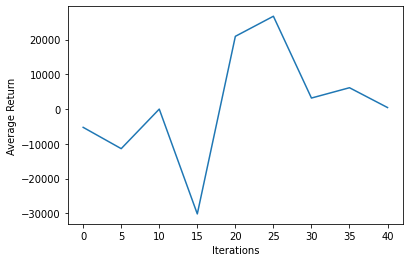

In [15]:
#visualize progress
iterations = range(0, num_iterations +1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
#plt.ylim(top=50000)

In [16]:
#run_simulation(eval_policy)
evaluatePolicy(eval_policy, eval_env)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
58.62355604166666
0
0
135.60857104166666
0
0
36.50857104166664
0
61.368966041666624
0
54.75358104166665
0
0
-6.05504895833343
driver reward  340.80819624999975
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
46.27912104166663
0
0
0
0
0
0
0
0
0
0
125.53737104166663
0
0
0
0
47.90857104166665
33.358571041666664
0
0
0
0
0
0
43.453581041666666
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
127.10970604166664
0
0
0
0
0
0
0
0
0
25.87912104166662
0
129.4597060416666
0
0
0
0
0
0
0
0
0
0
69.61916604166663
0
0
0
0
0
45.77912104166663
0
52.52355604166661
42.92355604166664
0
0
0
0
0
0
0
0
0
0
0
0
driver reward  789.8311474999996
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
55.09418604166666
0
0
0
0
0
0
0
27.423556041666643
0
67.5597060416666
0
0
0
0
14.358571041666622
20.40857104166662
57.62355604166663
0
0
0
114.11616104166666
0
-5.21167895833338
0
0
-8.461678958333351
-18.21167895833338
0
0
0
0
0
0
76.03737104166669
118.27198604166665
0
0
102.46616104166665
0
0
92.91337104

In [ ]:
#evaluate a trained policy with respect to a pre-generated static environment
def evaluateSavedPolicy(policy, policy_state, eval_env):
    episode_reward = 0
    for state_list in eval_env:
        states = []
        driver_reward = 0
        
        for i in range(len(state_list)):
            state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
            action = policy.action(state_tf, policy_state)
            #action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
            if (action[0].numpy() == 1):
                reward = state_list[i]["reward"]
            else:
                reward = 0
            print (reward)
            driver_reward += reward
        episode_reward += driver_reward
        print("driver reward ", driver_reward)
    print("total reward ", episode_reward)


In [ ]:
#load saved policy
saved_policy = tf.compat.v2.saved_model.load('pol/policy_10')
policy_state = saved_policy.get_initial_state(batch_size=3)
"""time_step = ...
while True:
  policy_step = saved_policy.action(time_step, policy_state)
  policy_state = policy_step.state
  time_step = f(policy_step.action)
"""
observations = [8, 10, 0, 35]
#observation_ts = ts.transition(np.array(observations, dtype=np.float32), reward=0.0, discount=1.0)
observation_ts = ts.TimeStep(tf.constant([1]), tf.constant([0.0]), tf.constant([1.0]),
                                tf.convert_to_tensor(np.array([observations], dtype=np.float32), dtype=tf.float32))
action = saved_policy.action(observation_ts, policy_state)
print(action)

In [ ]:
avg_return = compute_avg_return(saved_policy, num_eval_episodes)

In [ ]:
#evaluateSavedPolicy(saved_policy, policy_state, eval_env)
evaluatePolicy(eval_policy, eval_env)

In [ ]:
"""


reward results - 
random policy - around 9.5k
learned policy - 14k
always accept policy - 19.4k
"""

##############################################################################################



In [ ]:
# startup simulation

def simpy_episode(rewards, steps, time_step, tf_env, policy):

    TIME_MULTIPLIER = 50
    DRIVER_COUNT = 1
    TRIP_COUNT = 8000
    RUN_TIME = 10000
    INTERVAL = 20
    # GRID_WIDTH = 3809
    # GRID_HEIGHT = 2622
    GRID_WIDTH = 60
    GRID_HEIGHT = 40
    HEX_AREA = 2.6

    Env = simpy.Environment()
    map_grid = Grid(env=Env, width=GRID_WIDTH, height=GRID_HEIGHT, interval=INTERVAL, num_drivers=DRIVER_COUNT,
                    hex_area=HEX_AREA)

    taxi_spots = map_grid.taxi_spots
    driver_list = create_drivers(Env, DRIVER_COUNT, map_grid)
    driver_pools = map_grid.driver_pools

    run_simulation(TRIP_COUNT, RUN_TIME, DRIVER_COUNT, TIME_MULTIPLIER, map_grid, taxi_spots, driver_list, driver_pools, Env, rewards, steps, time_step, tf_env, policy)
    t_count = 0
    for dr in driver_list:
        d_t_count = dr.total_trip_count
        t_count += d_t_count
        print(f"{dr.id} completed {d_t_count}")

    print(f"Total trip count: {t_count}")

In [ ]:
var = tf.random.uniform([1], 0, 2, dtype=tf.int32)
var[0] = 2
print (var)

In [ ]:
#simple episode run - atttempt 1

time_step = tf_env.reset()
rewards = []
steps = []
num_episodes = 5

for _ in range(num_episodes):
    simpy_episode(rewards, step, time_step, tf_env, policy)

    action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
    time_step = tf_env.step(action)
    episode_steps += 1
    episode_reward += time_step.reward.numpy()
  rewards.append(episode_reward)
  steps.append(episode_steps)
  time_step = tf_env.reset()

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

In [ ]:
#simple episode run - atttempt 2

#time_step = tf_env.reset()
rewards = []
steps = []
num_episodes = 5

for _ in range(num_episodes):
    time_step = tf_env.reset()
    
    
    
    
    
    
    simpy_episode(rewards, step, time_step, tf_env, policy)

    action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
    time_step = tf_env.step(action)
    episode_steps += 1
    episode_reward += time_step.reward.numpy()
  rewards.append(episode_reward)
  steps.append(episode_steps)
  time_step = tf_env.reset()

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

In [ ]:
#simple episode run template
"""
time_step = tf_env.reset()
rewards = []
steps = []
num_episodes = 5

for _ in range(num_episodes):
  episode_reward = 0
  episode_steps = 0
  while not time_step.is_last():
    action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
    time_step = tf_env.step(action)
    episode_steps += 1
    episode_reward += time_step.reward.numpy()
  rewards.append(episode_reward)
  steps.append(episode_steps)
  time_step = tf_env.reset()

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

print('num_episodes:', num_episodes, 'num_steps:', num_steps)
print('avg_length', avg_length, 'avg_reward:', avg_reward)
"""